# Introduction
## ***A New Taste on Menu - What Strategy Will Make It Trendy?***

Nowadays, in competitive food industry introducing a new menu item is **not just about great taste - it's about launching with the right strategy**. Fast-food chains must choose their go-to-market approach wisely to ensure a product not only reaches customers but becomes popular.

A fast-food chain is planning to launch a new menu item and evaluate the effectiveness of three different marketing strategies for its promotion. To do this, an A/B test was conducted where each participating store location implemented a unique promotional campaign, and the weekly sales of the new item were tracked over a four-week period.

Context:

*   Each of the three promotions was applied to distinct store locations.
*   Sales data for the new item were recorded on a weekly basis for four weeks.


# Goal
The main purpose of this A/B test is to **evaluate the best marketing campaign which will prove to be the most efficacious in terms of number of sales** while introducing a new product launch.


# Target Metric
Main Metric will be **weekly sales estimates** (the `SalesInThousands` column). This metric directly measures the effectiveness of each promotion by revenue generated, aligning with the goal of finding the best marketing plan.

Why It Matters:

*   Directly reflects revenue impact.
*   Quantifies performance for actionable decisions.
*   Appropriate for testing promotion effectiveness.

##1. Neccessary imports

In [89]:
!pip install plotly

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
from statsmodels.stats.power import FTestAnovaPower
from scipy.stats import levene
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations

##2. Loading

In [91]:
campaign_data = pd.read_csv("WA_Marketing-Campaign.csv")
campaign_data.head()

MarketID MarketSize  LocationID  AgeOfStore  Promotion  week  \
0         1     Medium           1           4          3     1   
1         1     Medium           1           4          3     2   
2         1     Medium           1           4          3     3   
3         1     Medium           1           4          3     4   
4         1     Medium           2           5          2     1   

   SalesInThousands  
0             33.73  
1             35.67  
2             29.03  
3             39.25  
4             27.81

In [92]:
palette = ["#fc6f03", "#d13434", "#88f74d"]

##3. General Overview

In [93]:
campaign_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


Judging by the information the shape of the dataframe is **548 rows and 7 columns** with **no NULL** values and different data types.
There are **6 numerical** traits and **1 categorical**.

In [94]:
campaign_data.duplicated().sum()

np.int64(0)

Additionally, there are **no duplicates** in this dataset.

In [95]:
print(f"Dataset features: {', '.join(campaign_data.columns.tolist())}")

Dataset features: MarketID, MarketSize, LocationID, AgeOfStore, Promotion, week, SalesInThousands


In [96]:
fig = px.box(campaign_data, x="Promotion", y="SalesInThousands", color_discrete_sequence=palette)
fig.update_layout(
    title=dict(text="Sales Distribution By Promotion Type", x=0.5, xanchor="center"),
    title_font_size=18,
    xaxis_title="Promotion Type",
    yaxis_title="Sales in Thousands",
    font=dict(size=16),
)

In the light of the boxplot the findings clearly indicate that **there are outliers** in the data which might cause *distortion* and *false conclusions*.

In [97]:
Q1 = campaign_data.SalesInThousands.quantile(0.25)
Q3 = campaign_data.SalesInThousands.quantile(0.75)
IQR = Q3 - Q1
outliers = (campaign_data["SalesInThousands"] < Q1 - 1.5 * IQR) | (
    campaign_data["SalesInThousands"] > Q3 + 1.5 * IQR
)
print(f"There are {outliers.sum()} outliers in the dataset")

There are 33 outliers in the dataset


Outliers in sales data can arise for various legitimate reasons and **are not necessarily errors**. **Very low sales** may reflect real business conditions (small markets, poor locations). **Extremely high sales** might occur in large/high-traffic markets. **Sudden spikes/drops** could be data entry mistakes or one-time events. Investigate outliers before removing or adjusting them, as they may offer valuable insight.

In [98]:
Q1 = campaign_data.SalesInThousands.quantile(0.25)
Q3 = campaign_data.SalesInThousands.quantile(0.75)
IQR = Q3 - Q1
outliers = (campaign_data["SalesInThousands"] < Q1 - 1.5 * IQR) | (
    campaign_data["SalesInThousands"] > Q3 + 1.5 * IQR
)
outliers_info = campaign_data.loc[
    outliers, ["SalesInThousands", "MarketSize", "Promotion", "AgeOfStore"]
]

In [99]:
fig = px.scatter(
    campaign_data[outliers],
    x="AgeOfStore",
    y="SalesInThousands",
    color="MarketSize",
    color_discrete_sequence=palette,
)
fig.update_layout(
    title=dict(text="Outliers in Sales Data", x=0.5, xanchor="center", font_size=18),
    xaxis_title="Age of Store",
    yaxis_title="Sales in Thousands",
    font=dict(size=16),
)

Based on the data display, all of the outliers points are considered to be aligned with large market.

##4. Properties overview

Here is a brief overview of some key columns in the dataset:
* **MarketID**: unique identifier for market

* **MarketSize**: size of market area by sales

* **LocationID**: A distinct code for each store location.

* **AgeOfStore**: The number of years the store has been in operation.

* **Promotion**: Indicates which of the
three tested marketing strategies was used.

* **week**: Specifies one of the four weeks during which the promotions were active.

* **SalesInThousands**: The total sales amount, in thousands of currency units, for a particular store location, promotion, and week combination.

In [100]:
print(f"Number of unique stores in the dataset: {campaign_data.MarketID.nunique()}")

Number of unique stores in the dataset: 10


In [101]:
print(f"Number of unque store locations in the dataset: {campaign_data.LocationID.nunique()}")

Number of unque store locations in the dataset: 137


In [102]:
print(f"Unique sizes of stores in the dataset: {campaign_data.MarketSize.unique()}")

Unique sizes of stores in the dataset: ['Medium' 'Small' 'Large']


Number of unique stores does not allign with the number of unique locations which suggests that **there are multiple stores located in distinct locations**. There are three various sizes of markets: **Medium, Small and Large.**

In [103]:
print(f"Unique values of promotions in the dataset: {campaign_data.Promotion.unique()}")

Unique values of promotions in the dataset: [3 2 1]


In [104]:
print(f"Unique values of weeks in the dataset: {campaign_data.week.unique()}")

Unique values of weeks in the dataset: [1 2 3 4]


Data proves the fact that there are three **diverse promotions run for the first four weeks.**

In [105]:
campaign_data.describe()

MarketID  LocationID  AgeOfStore   Promotion        week  \
count  548.000000  548.000000  548.000000  548.000000  548.000000   
mean     5.715328  479.656934    8.503650    2.029197    2.500000   
std      2.877001  287.973679    6.638345    0.810729    1.119055   
min      1.000000    1.000000    1.000000    1.000000    1.000000   
25%      3.000000  216.000000    4.000000    1.000000    1.750000   
50%      6.000000  504.000000    7.000000    2.000000    2.500000   
75%      8.000000  708.000000   12.000000    3.000000    3.250000   
max     10.000000  920.000000   28.000000    3.000000    4.000000   

       SalesInThousands  
count        548.000000  
mean          53.466204  
std           16.755216  
min           17.340000  
25%           42.545000  
50%           50.200000  
75%           60.477500  
max           99.650000

In [106]:
campaign_data.Promotion.value_counts()

Promotion
3    188
2    188
1    172
Name: count, dtype: int64

In [107]:
total_sales_by_promotion = campaign_data.groupby("Promotion")["SalesInThousands"].sum().sort_values(ascending=False)
total_sales_by_promotion

Promotion
3    10408.52
1     9993.03
2     8897.93
Name: SalesInThousands, dtype: float64

In [108]:
total_sales_by_market_size = campaign_data.groupby("MarketSize")["SalesInThousands"].sum().sort_values(ascending=False)
total_sales_by_market_size

MarketSize
Medium    14075.31
Large     11779.61
Small      3444.56
Name: SalesInThousands, dtype: float64

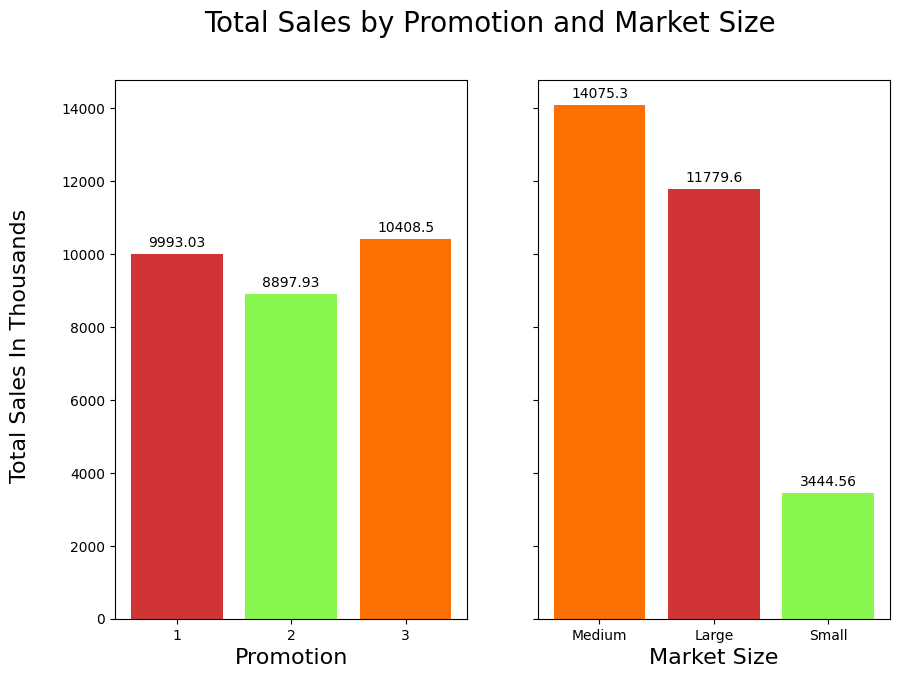

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7), sharey=True)
sns.set_palette("Blues")
axs[0].bar(
    x=total_sales_by_promotion.index,
    height=total_sales_by_promotion.values,
    color=palette,
)
axs[0].xaxis.set_major_locator(plt.MultipleLocator(1))
axs[0].set_xlabel("Promotion", fontsize=16)
axs[1].set_xlabel("Market Size", fontsize=16)
axs[1].bar(
    x=total_sales_by_market_size.index,
    height=total_sales_by_market_size.values,
    color=palette,
)
fig.suptitle("Total Sales by Promotion and Market Size", fontsize=20)
fig.supylabel("Total Sales In Thousands", fontsize=16)
a = [0, 1]


def bar_l(a):
  for container in axs[a].containers:
    axs[a].bar_label(container, padding=3)


for i in a:
  bar_l(i)

The bar charts clearly show that **Promotion 3 led to the highest total sales** among provided data, closely followed by Promotion 1, with Promotion 2 generating the lowest sales however **this could be due to the fact that there is unequal promotion group sizes**. The differences in total sales between the promotions are relatively small. Looking at market size, the **Medium market segment contributed the most to total sales**, followed by the Large and then the Small markets.

In [110]:
location_count = campaign_data.groupby(["MarketID", "Promotion"])["LocationID"].count().reset_index()
location_count = location_count.rename(columns={"LocationID": "LocationCount"})

In [111]:
location_count["Promotion_type"] = location_count.Promotion.astype(str)
fig = px.bar(
    location_count,
    x="MarketID",
    y="LocationCount",
    color="Promotion_type",
    barmode="group",
    color_discrete_sequence=palette,
)
fig.update_layout(
    title=dict(
        text="Number of Locations by Market and Promotion",
        x=0.5,
        xanchor="center",
        font_size=18,
    ),
    xaxis_title="Market ID",
    yaxis_title="Number of Locations",
    font=dict(size=16),
    xaxis=dict(tick0=1, dtick=1),
)

This plot represents the count of store locations within each distinct market, broken down by the promotion type running at those locations. It highlights that **Market ID 3 has the highest total number of locations**. Markets with ID 10, 5, 6, and 7 also have a significant number of locations.**The distribution of promotions varies across these markets**.

In [112]:
sales_count_per_week = campaign_data.groupby(["week", "Promotion"])["SalesInThousands"].sum().reset_index()
sales_count_per_week.head()

week  Promotion  SalesInThousands
0     1          1           2504.51
1     1          2           2243.32
2     1          3           2621.48
3     2          1           2447.97
4     2          2           2236.38

/tmp/ipython-input-113-4120291392.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-113-4120291392.py:16: UserWarning:


The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.



Text(0.02, 0.5, 'Total Sales in Thousands')

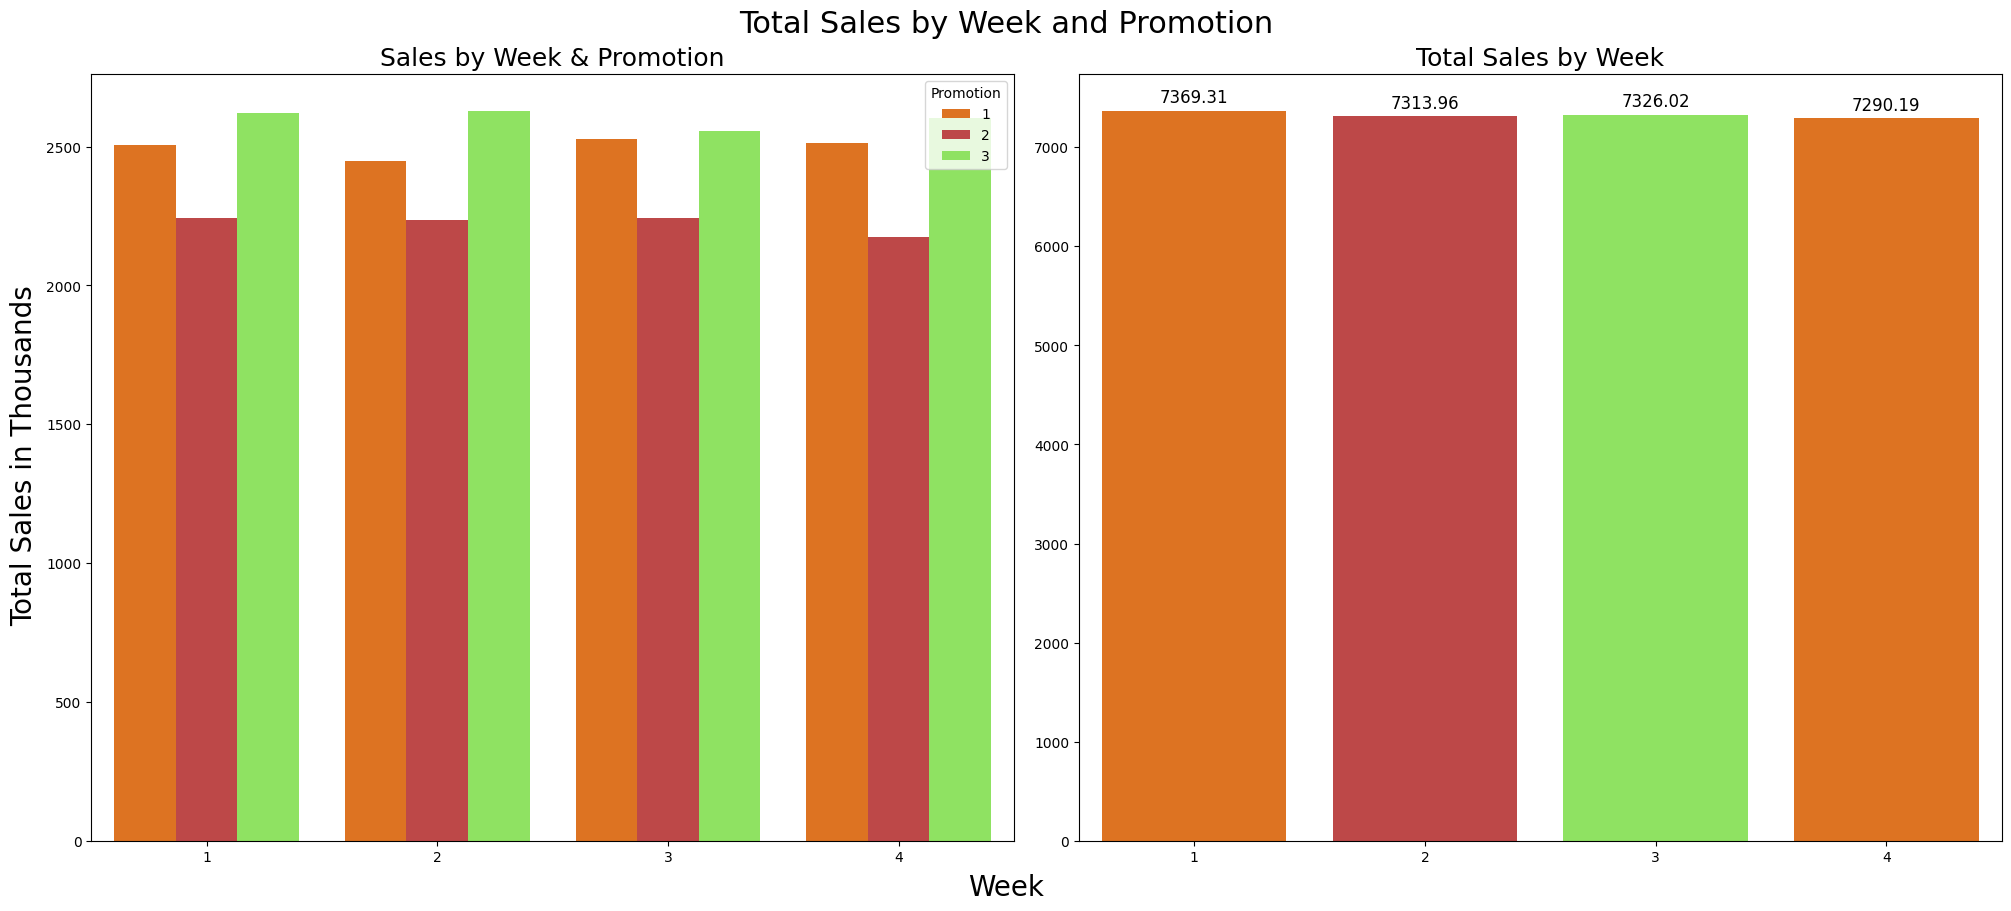

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(20, 9), constrained_layout=True)

sns.barplot(
    data=sales_count_per_week,
    x="week",
    y="SalesInThousands",
    hue="Promotion",
    ax=axs[0],
    palette=palette,
)
axs[0].set_title("Sales by Week & Promotion", fontsize=18)
axs[0].set_xlabel("")
axs[0].set_ylabel("")

total_weekly_sales = sales_count_per_week.groupby("week")["SalesInThousands"].sum().reset_index()
sns.barplot(
    data=total_weekly_sales,
    x="week",
    y="SalesInThousands",
    ax=axs[1],
    palette=palette,
)
axs[1].set_title("Total Sales by Week", fontsize=18)
axs[1].set_xlabel("")
axs[1].set_ylabel("")

for container in axs[1].containers:
    axs[1].bar_label(container, padding=3, fontsize=12)

fig.suptitle("Total Sales by Week and Promotion", fontsize=22)
fig.supxlabel("Week", fontsize=20)
fig.supylabel("Total Sales in Thousands", fontsize=20)


Looking at the weekly sales data, it's clear that **Promotion 3 consistently generated the highest sales each week**, followed by Promotion 1, and then Promotion 2. The total sales for each promotion remained relatively consistent across the four-week period. Additionally, the **total sales across all promotions combined were also relatively similar from week to week.**

In [114]:
sales_in_years = campaign_data.groupby(["AgeOfStore", "Promotion"])[
    "SalesInThousands"
].sum()
sales_by_age = sales_in_years.reset_index()
total_sales_by_age = (
    sales_by_age.groupby("AgeOfStore")["SalesInThousands"].sum().reset_index()
)
total_sales_by_age = total_sales_by_age.rename(
    columns={"SalesInThousands": "TotalSalesByAge"}
)
sales_in_years = pd.merge(sales_by_age, total_sales_by_age, on="AgeOfStore")
sales_in_years["PercentageOfTotalSales"] = (
    sales_in_years["SalesInThousands"] / sales_in_years["TotalSalesByAge"] * 100
)
sales_in_years["PercentageOfTotalSales"] = sales_in_years[
    "PercentageOfTotalSales"
].round()
sales_in_years.head()

AgeOfStore  Promotion  SalesInThousands  TotalSalesByAge  \
0           1          1           1578.75          4673.25   
1           1          2           1787.16          4673.25   
2           1          3           1307.34          4673.25   
3           2          1            608.90          1183.59   
4           2          2            345.39          1183.59   

   PercentageOfTotalSales  
0                    34.0  
1                    38.0  
2                    28.0  
3                    51.0  
4                    29.0

In [115]:
sales_in_years["Promotion_type"] = sales_in_years["Promotion"].astype(str)
fig = px.line(
    sales_in_years,
    x="AgeOfStore",
    y="SalesInThousands",
    color="Promotion_type",
    color_discrete_sequence=palette,
)
fig.update_layout(
    title=dict(
        text="Sales in Thousands by Age of Store and Promotion",
        x=0.5,
        xanchor="center",
        font_size=18,
    ),
    xaxis_title="Age of Store",
    yaxis_title="Sales in Thousands",
    font=dict(size=16),
)

Text(41.999999228395055, 0.5, 'Sales in Thousands')

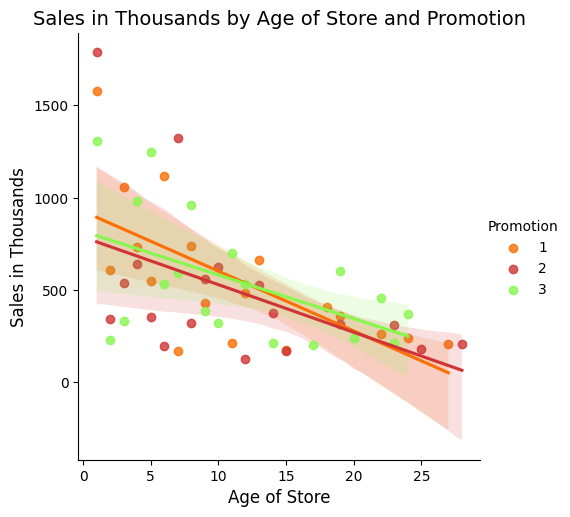

In [116]:
sns.lmplot(
    data=sales_in_years, x="AgeOfStore", y="SalesInThousands", hue="Promotion", palette=palette
)
plt.title("Sales in Thousands by Age of Store and Promotion", fontsize=14)
plt.xlabel("Age of Store", fontsize=12)
plt.ylabel("Sales in Thousands", fontsize=12)

The visualizations, particularly the scatter and line plots of **sales against store age** clearly portray a **negative correlation** between the age of the stores and the sales made. In other words, **the younger stores tend to achieve a larger number of sales in thousands compared to older stores** over the four-week period of the promotion. The linear model plot further supports this observation, showing a **downward trend in sales** as store age increases for **all campaigns**.

##5. A/B Testing
For this analysis there will be three properties tested and compared:

1. Promotion 1 and Promotion 2
2. Promotion 1 and Promotion 3
3. Promotion 2 and Promotion 3

The object of this test will be to **highlight contrast** between these marketing campaigns, **undertake evaluation** based on chosen metric(weekly sales) and **uncover which one performs best** over the period of four weeks.

/tmp/ipython-input-117-1236153538.py:2: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipython-input-117-1236153538.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Text(0, 0.5, 'Sales in Thousands')

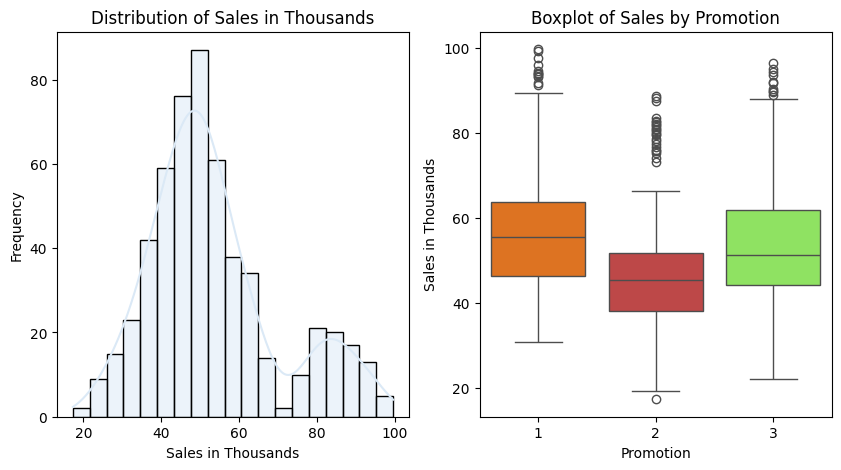

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(
    data=campaign_data, x="SalesInThousands", kde=True, ax=axs[0], palette=palette
)
sns.boxplot(
    data=campaign_data, x="Promotion", y="SalesInThousands", ax=axs[1], palette=palette
)
axs[0].set_title("Distribution of Sales in Thousands")
axs[0].set_xlabel("Sales in Thousands")
axs[0].set_ylabel("Frequency")
axs[1].set_title("Boxplot of Sales by Promotion")
axs[1].set_xlabel("Promotion")
axs[1].set_ylabel("Sales in Thousands")

### Requirements for ANOVA Test
* Normality of residuals
* Independence
* Equality of Variances

Although the data might be biased due to existent outliers in each category.

#### Independence
Markets were randomly chosen which increase the probability of random assignment.

#### Normality

In [118]:
effect_size = 0.25
alpha = 0.05
power = 0.8
k_groups = 3

analysis = FTestAnovaPower()
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, k_groups=k_groups)
print(f"Required sample size per group: {sample_size:.0f}")

Required sample size per group: 157


In [119]:
campaign_data.Promotion.value_counts()

Promotion
3    188
2    188
1    172
Name: count, dtype: int64

According to calculations all three categories of promotions count exceed number 157 which means that **sample size** might be considered **large enough**.

Text(0, 0.5, 'Sales in Thousands')

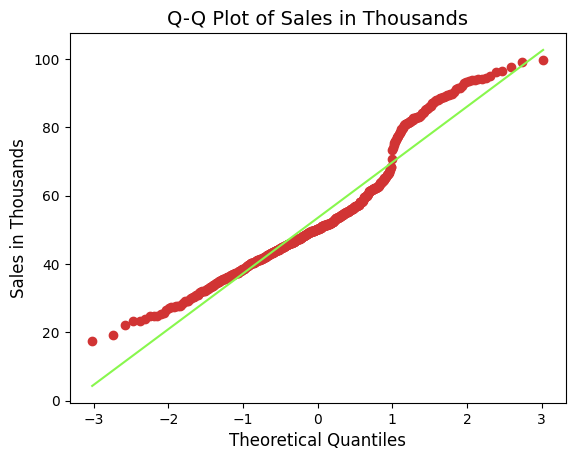

In [120]:
fig = stats.probplot(campaign_data["SalesInThousands"], dist="norm", plot=plt)
ax = plt.gca()
ax.get_lines()[0].set_color(palette[1])
ax.get_lines()[1].set_color(palette[2])
ax.set_title("Q-Q Plot of Sales in Thousands", fontsize=14)
ax.set_xlabel("Theoretical Quantiles", fontsize=12)
ax.set_ylabel("Sales in Thousands", fontsize=12)

Based on the data display in the Quantile-Quantile (Q-Q) plot against a normal distribution, the observation that most points are reasonably close to the line suggests that the **distribution of the data can be considered approximately normal**.

#### Equality of variance

In [121]:
promo1 = campaign_data[campaign_data.Promotion == 1]["SalesInThousands"]
promo2 = campaign_data[campaign_data.Promotion == 2]["SalesInThousands"]
promo3 = campaign_data[campaign_data.Promotion == 3]["SalesInThousands"]

stat, p = levene(promo1, promo2, promo3)
print(f"Levene's test p-values: {p:.4f}")

Levene's test p-values: 0.2818


P-value is higher than 0.05 which means that **there is no difference between the variances** in three campaign groups.

After checking all the neccessities for the ANOVA Test it's possible to undertake it for the reason that **data** is **most likely independent, normally distributed and with equal variance between variables**.

**Null Hypothesis**(H0): Three promotion plans do not differ and do not project any changes on deals made.

**Alternative Hypothesis**(H1): Promotion campaigns are substantially diverse and affect transactions in notable ways.

#### Statistics

In [122]:
def means(promotions) -> list:
  """
  Computing means for each promotion.
  :param promotions: list of strings of names of promotion groups
  :type promotions: list
  :return: list of means for each promotion version
  :rtype: list
  """
  sample_means = []
  for promo in promotions:
    sample_mean = campaign_data[campaign_data.Promotion == promo][
        "SalesInThousands"
    ].mean()
    sample_means.append(sample_mean)
  return sample_means


def std(promotions) -> list:
  """
  Calculating standard deviation of each promotion version.
  :param promotions: list of strings of names of promotion groups
  :type promotions: list
  :return: list of standard deviations for each promotion version
  :rtype: list
  """
  std_devs = []
  for promo in promotions:
    std_dev = campaign_data[campaign_data.Promotion == promo][
        "SalesInThousands"
    ].std()
    std_devs.append(std_dev)
  return std_devs


def n_count(promotions) -> list:
  """
  Process the size of each promotion group.
  :param promotions: list of strings of names of promotion groups
  :type promotions: list
  :return: list of sample sizes of each promotion type
  :rtype: list
  """
  n = []
  for promo in promotions:
    sample = campaign_data[campaign_data.Promotion == promo][
        "SalesInThousands"
    ].count()
    n.append(sample)
  return n

In [123]:
def se(n1, n2, s1, s2) -> (float, int):
  """
  Calculate pooled standard error and degrees of freedom.
  :param n1: sample size of group 1
  :type n1: int
  :param n2: sample size of group 2
  :type n2: int
  :param s1: standard deviation of group 1
  :type s1: float
  :param s2: standard deviation of group 2
  :type s2: float
  :return: pooled standard error and degrees of freedom
  :rtype: tuple
  """
  df = n1 + n2 - 2
  sp = np.sqrt((((n1 - 1) * np.power(s1, 2)) + ((n2 - 1) * np.power(s2, 2))) / df)
  pooled_se = sp * (np.sqrt((1 / n1) + (1 / n2)))
  return pooled_se, df

In [124]:
def t_score(df) -> float:
  """
  Calculate t-score values for ANOVA test.
  :param df: degrees of freedom
  :type df: int
  :return: t-score value
  :rtype: float
  """
  t_score_value = stats.t.ppf(1 - alpha / 2, df)
  return t_score_value

In [125]:
def ci(x1, x2, pooled_se, t_score_value) -> (float, float, float):
  """
  Estimating lower and upper bounds of confidence interval.
  :param x1: mean of group 1
  :type x1: float
  :param x2: mean of group 2
  :type x2: float
  :param pooled_se: pooled standard error
  :type pooled_se: float
  :param t_score_value: t-score value
  :type t_score_value: float
  :return: mean difference, lower bound, upper bound of confidence interval
  :rtype: tuple
  """
  mean_diff = x1 - x2
  ci_lower = mean_diff - (t_score_value * pooled_se)
  ci_upper = mean_diff + (t_score_value * pooled_se)
  return mean_diff, ci_lower, ci_upper

In [126]:
def ci_promo(promotions) -> None:
  """
  Evaluates and prints to the screen confidence intervals.
  :param promotions: list of string of names of promotion groups
  :type promotions: list
  :return: None
  :rtype: None

  """
  sample_means = means(promotions)
  std_devs = std(promotions)
  n = n_count(promotions)

  if len(n) < 2:
    raise ValueError("Need at least two groups for comparison.")

  pooled_se, df = se(n[0], n[1], std_devs[0], std_devs[1])

  if df <= 0:
    raise ValueError("Degrees of freedom must be positive.")

  t = t_score(df)
  mean_diff, ci_lower, ci_upper = ci(sample_means[0], sample_means[1], pooled_se, t)
  print(f"95% Confidence Interval: ({ci_lower:.4f}; {ci_upper:.4f})")

In [127]:
def bootstrap_mean_diff(group1, group2, n_iterations=1000) -> (float, float, float):
  """
  Asseses bootstrap confidence interval.
  :param group1: sample group 1
  :type group1: pd.Series
  :param group2: sample group 2
  :type group2: pd.Series
  :param n_iterations: number of iterations for bootstrapping
  :type n_iterations: int
  :return: mean differnce, lower,upper bounds of bootstrap confidence interval
  :rtype: tuple
  """
  diffs = []
  n1, n2 = len(group1), len(group2)

  for _ in range(n_iterations):
    sample1 = group1.sample(n=n1, replace=True)
    sample2 = group2.sample(n=n2, replace=True)
    diff = sample1.mean() - sample2.mean()
    diffs.append(diff)

  lower = np.percentile(diffs, 2.5)
  upper = np.percentile(diffs, 97.5)
  return np.mean(diffs), lower, upper

#### ANOVA Test


In [128]:
f_stat, p_value = f_oneway(promo1, promo2, promo3)
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.10f}")

F-statistic: 21.9535
P-value: 0.0000000007


Test results:
1. P-value < 0.05, which allows to **reject Null Hypothesis**.
2. F-statistic > 10 that reflects the variance among groups across whole dataset variance therefore highlights **high diversity between promotions**.

**Findings confirm that the marketing campaigns (unknown which ones yet) differ significantly**.

#### Post-Hoc Test
In order to comprehend what exact groups differ and how.

In [129]:
tukey = pairwise_tukeyhsd(endog=campaign_data.SalesInThousands, groups=campaign_data.Promotion, alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7696    0.0 -14.7738 -6.7654   True
     1      3  -2.7345 0.2444  -6.7388  1.2697  False
     2      3   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


According to Tukey HSD Test results **Promotion 3 and Promotion 2 as well as Promotion 1 and Promotion 2 differ markedly** with **Promotion 1 and Promotion 3 being quite similar** in terms of proceeds.

#### Confidence Intervals
* Promotion 1 and Promotion 2
* Promotion 1 and Promotion 3
* Promotion 2 and Promotion 3

In [130]:
pairs = [[1, 2], [1, 3], [2, 3]]


def ci_pairs(pairs) -> None:
  """
  Evaluates confidence intervals between pairs of promotions.
  :param pairs: list of promotion pairs
  :type pairs: list
  :return: None
  :rtype: None
  """

  for pair in pairs:
    print(f"PROMOTION {pair[0]} VS PROMOTION {pair[1]}\n")
    group1 = campaign_data[campaign_data.Promotion == pair[0]]["SalesInThousands"]
    group2 = campaign_data[campaign_data.Promotion == pair[1]]["SalesInThousands"]
    diff, ci_low, ci_high = bootstrap_mean_diff(group1, group2)
    ci_promo(pair)
    print(f"Bootstrap confidence interval: ({ci_low:.4f};{ci_high:.4f})\n")
    print("-" * 100)


ci_pairs(pairs)

PROMOTION 1 VS PROMOTION 2

95% Confidence Interval: (7.4878; 14.0514)
Bootstrap confidence interval: (7.4859;14.0472)

----------------------------------------------------------------------------------------------------
PROMOTION 1 VS PROMOTION 3

95% Confidence Interval: (-0.7235; 6.1926)
Bootstrap confidence interval: (-0.6194;6.0507)

----------------------------------------------------------------------------------------------------
PROMOTION 2 VS PROMOTION 3

95% Confidence Interval: (-11.2717; -4.7984)
Bootstrap confidence interval: (-11.4880;-4.8222)

----------------------------------------------------------------------------------------------------


Based on the confidence intervals for the pairwise comparisons:

1.  **Promotion 1 vs. Promotion 2:** The interval is above zero, indicating **significantly higher sales for Promotion 1** compared to Promotion 2.
2.  **Promotion 1 vs. Promotion 3:** The interval includes zero, suggesting **no statistically significant difference** in sales between Promotion 1 and Promotion 3.
3.  **Promotion 2 vs. Promotion 3:** The interval is below zero (or above for Promotion 3 vs. 2), showing **significant higher sales for Promotion 3** compared to Promotion 2.

These results are consistent with the ANOVA and Tukey HSD tests. Bootstrapping was also used to estimate confidence intervals, and while the overall conclusions are similar, *slight differences* in the interval bounds are expected due to the *resampling nature of bootstrapping* compared to the theoretical basis of analytical tests.

##6. Possible innacuracies

Due to the presence of outliers in the sales data and the limited four-week duration of the promotional period, the findings of this A/B test should be interpreted with caution.

**Potential biases and limitations:**

*   **Outliers:** While overall statistical significance might be robust due to sample size, unidentified outlier causes could still impact mean/CI precision.
*   **Short Study Period:** Four weeks may not capture long-term effects, typical weekly variability, or seasonal trends.
*   **Market Size Variation:** Uneven promotion distribution across Small, Medium, Large markets, or different sales impact by size, could introduce bias.
*   **Store Age Correlation:** Younger stores tend to have higher sales; uneven promotion assignment across store ages could affect observed sales differences.
*   **Uncontrolled Factors:** External influences like local events, varying competition, or other unrecorded factors could confound the promotion effects.

**Acknowledging these factors is important for a comprehensive understanding of the A/B test results and when translating them into business decisions.**

##7. Final Conclusions

This A/B test was conducted to evaluate the effectiveness of three different marketing promotions (Promotion 1, Promotion 2, and Promotion 3) on the weekly sales of a new menu item over a four-week period. The primary goal was to identify the best performing promotion in terms of sales generated. The test involved stores of varying ages and sizes, with promotions distributed across different market sizes (Small, Medium, and Large). Notably, the **Medium market size contributed the most** to overall sales. The analysis also revealed a tendency for **younger stores to have higher sales** during the promotional period, regardless of the specific promotion.

Based on the statistical analysis, including ANOVA and pairwise comparisons (Tukey HSD and confidence intervals), the following key conclusions can be drawn:

*   **Promotion 2 was significantly less effective:** Promotion 2 resulted in statistically significantly lower mean sales compared to both Promotion 1 and Promotion 3.
*   **Promotion 1 and Promotion 3 performed comparably:** There was no statistically significant difference in the mean sales between Promotion 1 and Promotion 3. While **Promotion 3 had slightly higher total sales overall**, the difference in average sales was not statistically distinct within the timeframe and data available.



## **Answer To Question**
### A New Taste on Menu - What Strategy Will Make It Trendy? -

Based on these results, ***the fast-food chain should avoid implementing Promotion 2 for the new menu item launch due to its significantly lower performance***. The choice between Promotion 1 and Promotion 3 is less clear from a statistical standpoint alone. Both are viable options and performed significantly better than Promotion 2. The final decision between Promotion 1 and Promotion 3 could be based on other *business factors such as implementation costs, logistical ease, or alignment* with long-term marketing strategies, as the statistical evidence from this test does not conclusively favor one over the other.

*It's important to interpret these findings considering the **potential limitations** discussed earlier, such as the short study period and the presence of outliers*.

##8. Potential Improvements
1. To better comprehend campaign performance include **more additional variables** such as promotional costs,store traffic, demographics, etc..
2. **Increading participating locations and extending the time frame** might enhance statictical power and accuracy.
3. **Segment customer behavior** by breaking down the results by customer type and time of day/week to understand whether certain promotions work better for certain audiences or contexts.